<img src="https://drive.google.com/uc?export=view&id=1-G_iQyFJElMOz2ICxr82FdivRcEXWXDj" height="100" align="center">

<h1 align="left">
RIME-21 SMME NUST
</h1>

*   Muhammad Faiq Malik    --------    364542
*   Hussain Nasir Khan     --------    363654
*   Muhammad Uzair Memon   --------    364045

<h1 align="center">
    Deep Learning Project Part O2
</h1>
<h1 align="center">
    Covid19 Detection  
</h1>

# Project Description:

In this project, I am using the subset of two datasets. The first dataset has chest CT image repository of 1000+ patients
with confirmed COVID‑19 diagnosis. All the images are stored in DICOM standard. From this dataset, I am using the data of 50 subjects. The second dataset consists of chest CT scans with COVID-19 related findings, as well as without such findings. From this dataset, I am using the data of 50 subjects that are without COVID-19 related findings. All the images are stored in NIfTI standard. The datasets are:

1. COVID19‑CT‑dataset: an open‑access chest CT image repository of 1000+ patients with confirmed COVID‑19 diagnosis
2. MosMedData: Chest CT Scans with COVID-19 Related Findings Dataset


## Table of Content

- [1 - Packages](#1)
- [2 - Load, Process, and Split the Data](#2)
- [3 - Model Details](#3)
    - [3.1 - Model Summary and Visualization](#3-1)
- [4 - Train the Model](#4)
    - [4.1 - Plotting Model Accuracies per epoch](#4-1)
    - [4.2 - Model Testing](#4-2)
    - [4.3 - Model Evaluation Metrics](#4-3)
    - [4.4 - Random image testing](#4-4)

<a name='1'></a>
## 1 - Packages
To import all the libraries required:

In [4]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 8.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import os
import zipfile

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import nibabel as nib
import visualkeras
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers
import h5py

<a name='2'></a>

## 2 - Load, Process, and Split the Data

In [7]:
!gdown 1Gj2wJSOzrVaAqZLuRzOzdc5IGa2UtNvO

Downloading...
From: https://drive.google.com/uc?id=1Gj2wJSOzrVaAqZLuRzOzdc5IGa2UtNvO
To: /kaggle/working/data.zip
100%|███████████████████████████████████████| 7.44G/7.44G [00:42<00:00, 174MB/s]


In [8]:
# Unzip the data
z = zipfile.ZipFile('/kaggle/working/data.zip')
z.extractall()

In [9]:
# Function for Reading Nifti Files
def read_nifti_file(filepath):
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

In [10]:
# Function for Normalizing the Volume
def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [38]:
# Function for Resizing the Volume
def resize_volume(img):
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [39]:
# Function for implementing all the above three functions
def process_scan(path):
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [40]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "/kaggle/working/content/drive/MyDrive/3d_Data/NON_COVID", x)
    for x in os.listdir("/kaggle/working/content/drive/MyDrive/3d_Data/NON_COVID")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "/kaggle/working/content/drive/MyDrive/3d_Data/COVID", x)
    for x in os.listdir("/kaggle/working/content/drive/MyDrive/3d_Data/COVID")
]
print(len(abnormal_scan_paths))
print(len(normal_scan_paths))

50
50


In [41]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths[:50]])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths[:50]])

In [42]:
abnormal_scans.shape

(50, 128, 128, 64)

In [43]:
normal_scans.shape

(50, 128, 128, 64)

In [50]:
# For the CT scans having presence of COVID assign 1, for the NONCOVID assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [51]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:35], normal_scans[:35]), axis=0)
y_train = np.concatenate((abnormal_labels[:35], normal_labels[:35]), axis=0)
x_val = np.concatenate((abnormal_scans[35:], normal_scans[35:]), axis=0)
y_val = np.concatenate((abnormal_labels[35:], normal_labels[35:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 70 and 30.


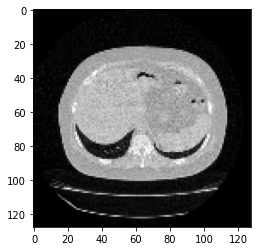

In [52]:
plt.imshow(x_train[1, :, :, 13], cmap='gray')

In [53]:
# Data augmentation
import random
from scipy import ndimage
@tf.function

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [54]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


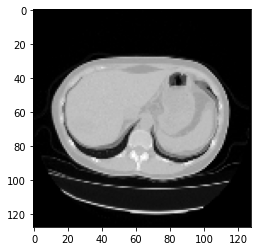

In [55]:
# Visualize an augmented CT scan

import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 12]), cmap="gray")

<a name='3'></a>

## 3 - Model Details

The feature extraction block follows a similar pattern to VGGNET two conv layers followed by a maxpool however the kernel size for each conv layer follows my registration number in reverse order. 363654 to 456363 so for first layer the kernel size will be 4+1= 5x5 then 5*5 for second layer. Sigmoid activation function is used in last dense layer for binary classification. 
The network has 6 convolutional layers, 3 pooling layers, 7 normalization layers, 5 dropout layers, and two dense layers.

In [56]:
# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv3D(32, (5, 5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 64, 1)))
  model.add(BatchNormalization())
  model.add(Conv3D(32, (5, 5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D((2, 2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv3D(64, (7, 7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D((2, 2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv3D(128, (7, 7, 7), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D((2, 2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        name="Adam",
    ),
   loss='binary_crossentropy',
   metrics=['accuracy']
    )
  return model

<a name='3-1'></a>
### 3.1 - Model Summary and Visualization

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 128, 128, 64, 32)  4032      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64, 32)  128       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 128, 128, 64, 32)  128032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 32, 32)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32, 32)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 64, 64, 32, 64)   

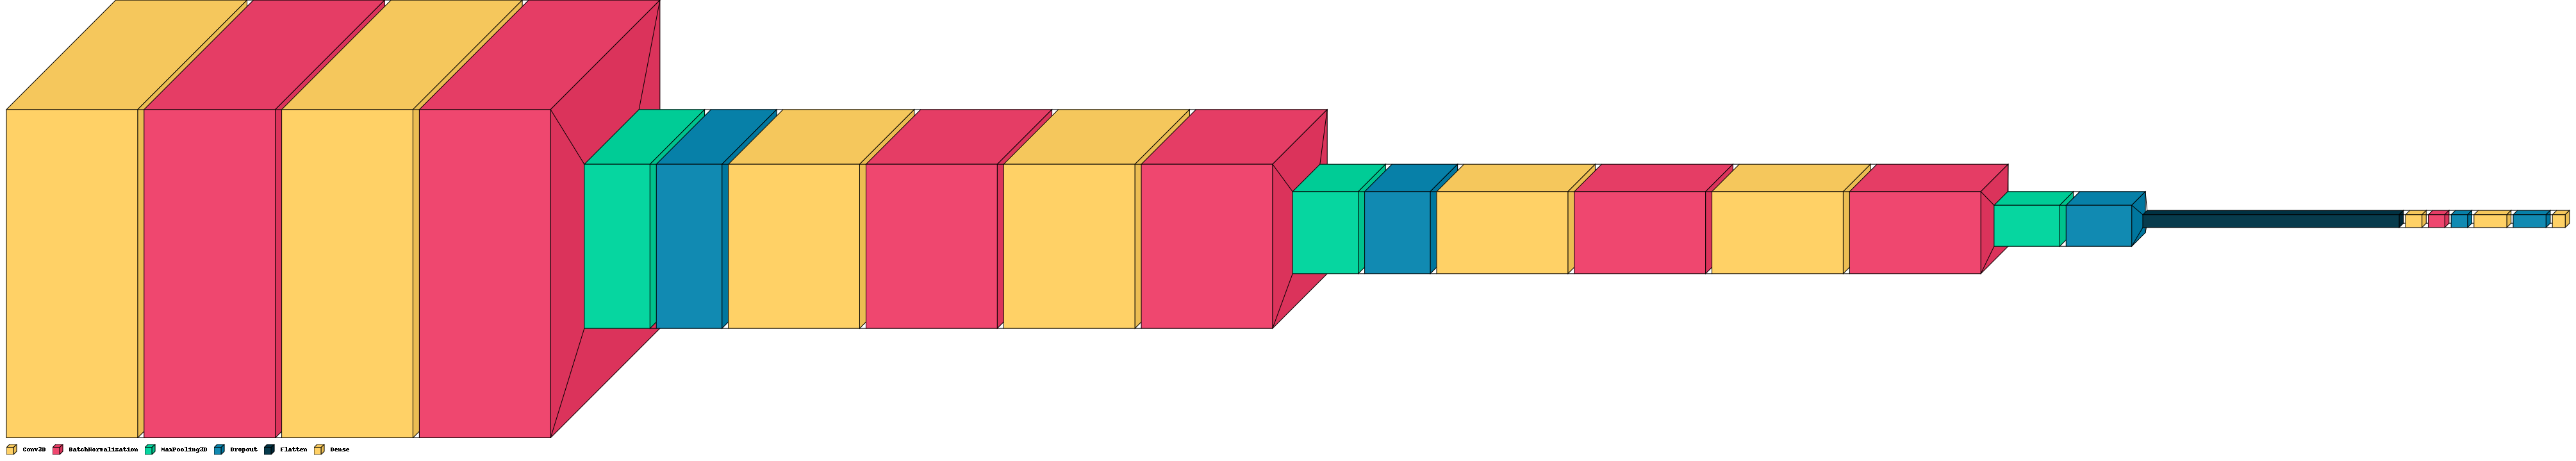

In [58]:
visualkeras.layered_view(model, legend=True)

<a name='4'></a>
## 4 - Model Training

In [59]:
model.compile(Adam(0.001),'binary_crossentropy',['accuracy'])
history = model.fit(  train_dataset,
            steps_per_epoch=len(x_train)//batch_size,
            epochs=30,
            validation_data=validation_dataset,
            #callbacks = [checkpoint, callback],
            validation_steps=len(x_val)//batch_size )

Epoch 1/30
35/35 [==============================] - 66s 2s/step - loss: 0.9220 - accuracy: 0.5714 - val_loss: 28.6420 - val_accuracy: 0.5333
Epoch 2/30
35/35 [==============================] - 54s 2s/step - loss: 0.6188 - accuracy: 0.6857 - val_loss: 109.2188 - val_accuracy: 0.5000
Epoch 3/30
35/35 [==============================] - 54s 2s/step - loss: 0.5732 - accuracy: 0.7286 - val_loss: 1.6590 - val_accuracy: 0.7667
Epoch 4/30
35/35 [==============================] - 54s 2s/step - loss: 0.6909 - accuracy: 0.6857 - val_loss: 6.8947 - val_accuracy: 0.5333
Epoch 5/30
35/35 [==============================] - 54s 2s/step - loss: 0.8069 - accuracy: 0.6429 - val_loss: 8.1244 - val_accuracy: 0.3667
Epoch 6/30
35/35 [==============================] - 54s 2s/step - loss: 0.8812 - accuracy: 0.6000 - val_loss: 17.2035 - val_accuracy: 0.5000
Epoch 7/30
35/35 [==============================] - 53s 2s/step - loss: 0.7363 - accuracy: 0.7000 - val_loss: 2.7192 - val_accuracy: 0.7333
Epoch 8/30
35/35

<a name='4-1'></a>
### 4.1 - Plotting Model Accuracies per epoch

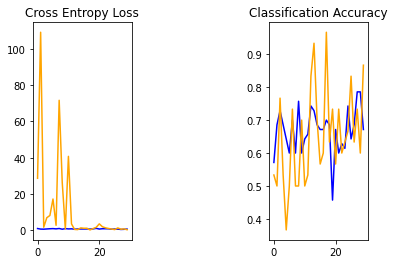

In [60]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(131)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(133)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.show()
 
summarize_diagnostics(history)

<a name='4-2'></a>
### 4.2 - Model Testing

In [61]:
_, acc = model.evaluate(train_dataset)
print('training accuracy:', str(round(acc*100, 2))+'%')
_, acc = model.evaluate(validation_dataset)
print('testing accuracy:', str(round(acc*100, 2))+'%')

35/35 [==============================] - 13s 355ms/step - loss: 0.2629 - accuracy: 0.8857
training accuracy: 88.57%
15/15 [==============================] - 6s 359ms/step - loss: 0.2689 - accuracy: 0.8667
testing accuracy: 86.67%


<a name='4-3'></a>
### 4.3 - Model Evaluation Metrics

In [91]:
y_pred = model.predict(validation_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = list(y_pred)

In [92]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(y_val,y_pred)
cm = confusion_matrix(y_val,y_pred)

print(cf_report)

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        15
           1       0.47      0.47      0.47        15

    accuracy                           0.47        30
   macro avg       0.47      0.47      0.47        30
weighted avg       0.47      0.47      0.47        30



Text(0.5, 51.0, 'Predicted')

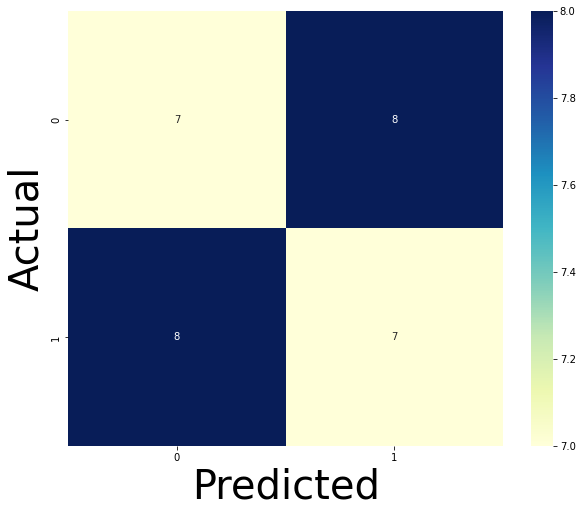

In [93]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, cmap='YlGnBu', annot=True, square=True)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

<a name='4-4'></a>
### 4.4 - Random image testing

### Sample 1

In [107]:
i_path = "/kaggle/working/content/drive/MyDrive/3d_Data/COVID/Subject (1036).nii.gz"
testing_scans = np.array([process_scan(i_path)])

In [115]:
prediction = model.predict(np.expand_dims(testing_scans,axis=-1))
scores = [1 - prediction[0], prediction[0]]
class_names = ["Non-COVID", "COVID"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 4.55 percent confident that CT scan is Non-COVID
This model is 95.45 percent confident that CT scan is COVID


### Sample 2

In [117]:
!gdown 1o2-YImFZZba9rq-pD_aHdm9HHO_hVhc2

Downloading...
From: https://drive.google.com/uc?id=1o2-YImFZZba9rq-pD_aHdm9HHO_hVhc2
To: /kaggle/working/Subject (1088).nii.gz
100%|████████████████████████████████████████| 136M/136M [00:03<00:00, 34.7MB/s]


In [118]:
i_path = "/kaggle/working/Subject (1088).nii.gz"
testing_scan2 = np.array([process_scan(i_path)])

prediction = model.predict(np.expand_dims(testing_scan2,axis=-1))
scores = [1 - prediction[0], prediction[0]]
class_names = ["Non-COVID", "COVID"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 50.52 percent confident that CT scan is Non-COVID
This model is 49.48 percent confident that CT scan is COVID
